In [1]:
import pandas as pd
import numpy as np
from dotenv import dotenv_values, find_dotenv
import matplotlib.pyplot as plt
import os
config = dotenv_values(find_dotenv())
path_cleandata = os.path.abspath(config["CLEANDATA"]) + '\\'
path_figures = os.path.abspath(config["FIGURES"]) + '\\'

In [93]:
# import my merged data
data = pd.read_pickle(path_cleandata + 'BEA6_naics6_merged.pkl')

In [94]:
# filter for the year 2017 
data2017 = data[data['date'].dt.year == 2017]

In [95]:
# personal consumption expenditures
data2017 = data2017[data2017['product_O'].str.contains('Personal consumption expenditures')][['product_I', 'date', 'IO_value', 'expenditures_I']]

In [96]:
# sum by product for that year
# first groupby: take sum of IO_value and mean of expenditures_I by date and product
byproduct = data2017.groupby(['product_I']).agg({
    'IO_value': 'mean',
    'expenditures_I': 'mean'}, min_count=1).reset_index()


In [97]:
byproduct.set_index('product_I')[['IO_value', 'expenditures_I']].sum(axis=0)

IO_value          10855175.0
expenditures_I    15028760.5
dtype: float64

## taking a look at how well the merge worked

In [98]:
# create distance variable
byproduct['distance'] = np.abs(byproduct['IO_value'] - byproduct['expenditures_I'])

# kinda "outliers" that have a very different value
outlier_threshold = 100000

# Filter only the points that are outliers
outliers = byproduct[byproduct['distance'] > outlier_threshold]

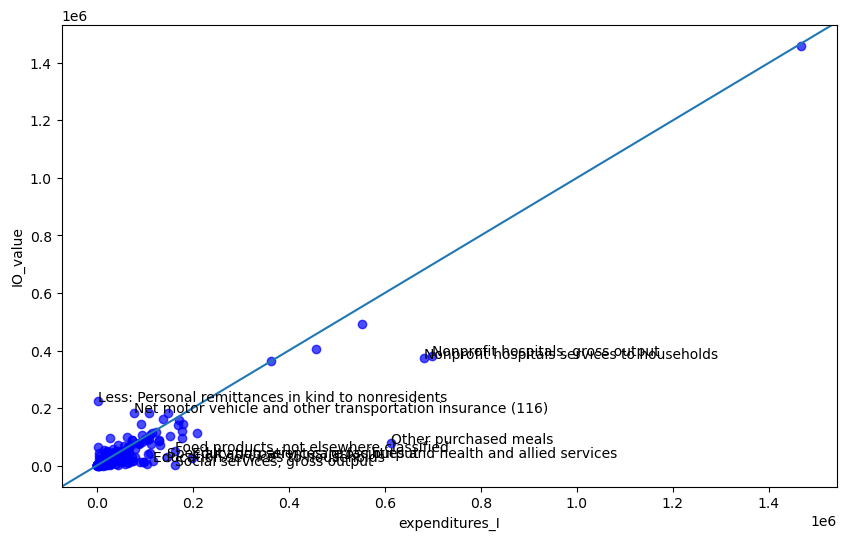

In [99]:
# do the scatter plot with expenditures on the x axis

plt.figure(figsize=(10, 6))
plt.scatter(byproduct['expenditures_I'], byproduct['IO_value'], c='blue', alpha=0.7)

plt.xlabel('expenditures_I')
plt.ylabel('IO_value')

ax = plt.gca()
ax.axline((0, 0), slope=1)

# annotations for outliers
for idx, row in outliers.iterrows():
   ax.annotate(row['product_I'].strip(), (row['expenditures_I'], row['IO_value']))

plt.savefig(path_figures + 'merge_check\\expenditures.pdf')

In [100]:
# this is the list of "outlier" products: issues mostly come from housing and healthcare type stuff
# noting the 2017 expenditures for tenant-occupied stationary houses is 0: having trouble getting min_count to work (actually all NaNs)
# within the merge, foreign travel in the United States gets matched with the rest-of-world adjustment in the IO table, which i should probably get rid of
outliers

,product_I,IO_value,expenditures_I,distance
38,Education services to households,15376.159411,116586.00,101209.840589
39,"Education services, gross output",27081.758043,198067.25,170985.491957
54,"Food products, not elsewhere classified",49024.000000,161953.75,112929.750000
93,Less: Personal remittances in kind to nonresid...,222777.000000,1562.25,221214.750000
119,Net motor vehicle and other transportation ins...,184209.628790,77603.00,106606.628790
129,Nonprofit hospitals services to households,373418.046349,681856.00,308437.953651
130,"Nonprofit hospitals, gross output",382457.547759,698362.00,315904.452241
142,Other purchased meals,78590.392620,611960.75,533370.357380
196,"Social services, gross output",791.626991,163448.75,162657.123009
197,Specialty outpatient care facilities and healt...,29419.000000,146815.00,117396.000000


In [101]:
# go into concordance, which shows some of the issues

concordance = pd.read_pickle(path_cleandata + 'concordance//concordance6_naics6_addproportions.pkl')
outlierproducts = list(outliers['product_I'])

outliermerges = concordance[concordance['product'].isin(outlierproducts)]
outliermerges



,product,NAICS_desc,IO_proportions
18,Specialty outpatient care facilities and healt...,Other ambulatory health care services,1.000000
95,Net motor vehicle and other transportation ins...,Direct life insurance carriers,0.720444
96,Net motor vehicle and other transportation ins...,"Insurance carriers, except direct life",0.386514
97,Net motor vehicle and other transportation ins...,Motor vehicle and parts dealers,0.334140
98,"Social services, gross output",Employment services,0.421302
243,Less: Personal remittances in kind to nonresid...,Less: Subsidies,0.317724
244,Less: Personal remittances in kind to nonresid...,Lessors of nonfinancial intangible assets,1.000000
245,Less: Personal remittances in kind to nonresid...,Used and secondhand goods,1.000000
280,Nonprofit hospitals services to households,Hospitals,0.359334
360,"Education services, gross output",Other educational services,0.381495


c:\Users\EmilyFu\.conda\envs\myenv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


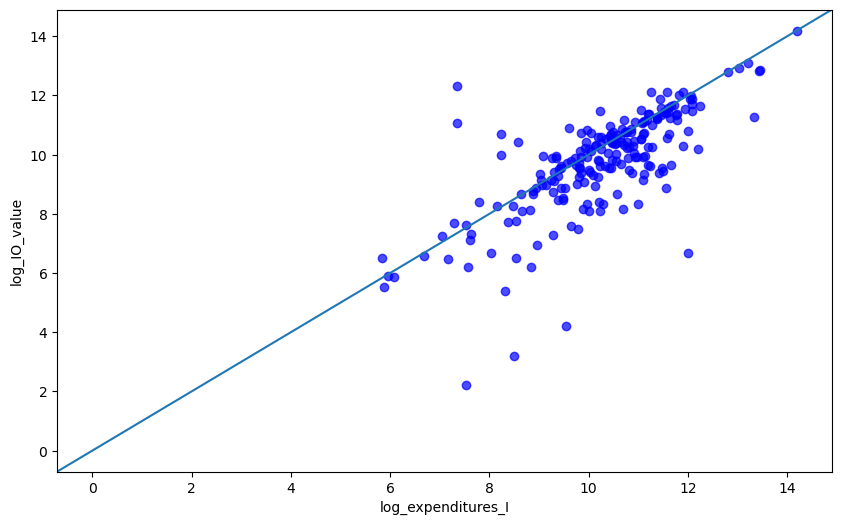

In [102]:
# get logs of everything and do an equivalent scatter plot with those

# do the scatter plot with expenditures on the x axis
plt.figure(figsize=(10, 6))
plt.scatter(np.log(byproduct['expenditures_I']), np.log(byproduct['IO_value']), c='blue', alpha=0.7)

plt.xlabel('log_expenditures_I')
plt.ylabel('log_IO_value')

ax = plt.gca()
ax.axline((0, 0), slope=1)

plt.savefig(path_figures + 'merge_check\\log_expenditures.pdf')
